# 分析Prosper数据——EDA

## 目录
* [项目综述](#项目综述)
* [分析过程](#分析过程)
 * [了解数据内容](#了解数据内容)
 * [单变量分析](#单变量分析)
 * [单变量分析总结](#单变量分析总结)
 * [双变量分析](#双变量分析)

### 项目综述
项目数据源是Prosper的数据。Prosper是美国一家不同于传统借贷的P2P借贷服务的公司，服务内容是贷款人贷款和借款人获取投资收益，而公司收益是从贷方和借方收取服务费。本次项目是站在投资人的角度，投资的收益是从借款人如约还款来实现，利用EDA的思路分析投资价值——因此需要分析借款人的借款信息和还款信息，期望能够证实P2P借贷方式存在投资价值。

In [1]:
library(ggplot2)
library(RColorBrewer)
library(psych)
library(dplyr)
library(tidyr)
library(reshape2)
library(gridExtra)


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [259]:
bivariate_theme <- theme(axis.text=element_text(size=6), plot.title=element_text(size=10, color="#006400"),
          axis.title=element_text(size=10))

In [2]:
# load data
rawprosper <- read.csv("prosperLoanData.csv", sep=",", stringsAsFactor=FALSE)

In [3]:
dim(rawprosper)

[1] 113937     81

In [4]:
# know the structure of the data
str(rawprosper)

'data.frame':	113937 obs. of  81 variables:
 $ ListingKey                         : chr  "1021339766868145413AB3B" "10273602499503308B223C1" "0EE9337825851032864889A" "0EF5356002482715299901A" ...
 $ ListingNumber                      : int  193129 1209647 81716 658116 909464 1074836 750899 768193 1023355 1023355 ...
 $ ListingCreationDate                : chr  "2007-08-26 19:09:29.263000000" "2014-02-27 08:28:07.900000000" "2007-01-05 15:00:47.090000000" "2012-10-22 11:02:35.010000000" ...
 $ CreditGrade                        : chr  "C" "" "HR" "" ...
 $ Term                               : int  36 36 36 36 36 60 36 36 36 36 ...
 $ LoanStatus                         : chr  "Completed" "Current" "Completed" "Current" ...
 $ ClosedDate                         : chr  "2009-08-14 00:00:00" "" "2009-12-17 00:00:00" "" ...
 $ BorrowerAPR                        : num  0.165 0.12 0.283 0.125 0.246 ...
 $ BorrowerRate                       : num  0.158 0.092 0.275 0.0974 0.2085 ...
 $ LenderY

In [5]:
print(sort(names(rawprosper)))

 [1] "AmountDelinquent"                    "AvailableBankcardCredit"            
 [3] "BankcardUtilization"                 "BorrowerAPR"                        
 [5] "BorrowerRate"                        "BorrowerState"                      
 [7] "ClosedDate"                          "CreditGrade"                        
 [9] "CreditScoreRangeLower"               "CreditScoreRangeUpper"              
[11] "CurrentCreditLines"                  "CurrentDelinquencies"               
[13] "CurrentlyInGroup"                    "DateCreditPulled"                   
[15] "DebtToIncomeRatio"                   "DelinquenciesLast7Years"            
[17] "EmploymentStatus"                    "EmploymentStatusDuration"           
[19] "EstimatedEffectiveYield"             "EstimatedLoss"                      
[21] "EstimatedReturn"                     "FirstRecordedCreditLine"            
[23] "GroupKey"                            "IncomeRange"                        
[25] "IncomeVerifiable"     

### 了解数据内容
该数据集的观测值为113937个，具有81个变量。变量中包括了借款人的信息：借款人类似ID信息(MemberKey)，借款人借款开始日期(LoanOriginationDate)，借款人所在州(BorrowerState)，收入范围(IncomeRange)，债务收入比(DebtToIncomeRatio)，职业(Occupation)，借款人工作期间(EmploymentStatusDuration)，借款人工作状态(EmploymentStatus)，借款总额度(LoanOriginalAmount)，还款策略(Term)，账户信用等级(ProsperRating..Alpha.)，借款后经过月数(LoanMonthsSinceOrigination)，交易数量(TotalTrades)，未发生延期交易的比例(TradesNeverDelinquent..percentage.)；另一方面，承担借款额的投资人人数(Investor)，投资款来自朋友的投资人数(InvestmentFromFriendsCount)，来自朋友投资的投资额(InvestmentFromFriendsAmount)。
以上也是本次分析的参考的变量，主要是考虑从了解借款人的收入、债务信息的侧写；另一方面也需要分析投资人在借款人中借款额度中影响，从两个方面去了解借款人的借款合理性、还款能力。以期待能了解Prosper借款用户的特点，分析其投资价值。

In [6]:
# change the data type
rawprosper$LoanOriginationDate <- as.Date(rawprosper$LoanOriginationDate)
rawprosper$MemberKey <- factor(rawprosper$MemberKey)
rawprosper$ProsperRating..Alpha. <- ordered(rawprosper$ProsperRating..Alpha., levels=unique(rawprosper$ProsperRating..Alpha.), 
                                            labels=c("NA", "HR", "E","D", "C", "B", "A", "AA"))
rawprosper$IncomeRange <- ordered(rawprosper$IncomeRange,levels=unique(rawprosper$IncomeRange),
                                 labels=c("$0", "$1-24,999", "$25,000-49,999", "$50,000-74999", "$75,000-99,999", "$100,000+", "Not employed","Not displayed"))
rawprosper$Occupation <- factor(rawprosper$Occupation)
rawprosper$EmploymentStatus <- factor(rawprosper$EmploymentStatus,
                                      levels=c('', 'Employed', 'Full-time', 'Not available', 'Not employed', 'Other', 'Part-time', 'Retired', 'Self-employed'),
                                     labels=c("NA", 'Employed', 'Full-time', 'Not available', 'Not employed', 'Other', 'Part-time', 'Retired', 'Self-employed'))


In [7]:
# show unnormal variable name
for (key in names(rawprosper)) {
    if (length(grepRaw(pattern="\\.$", key))>0) {
        print("Loacation:")
        print(which(names(rawprosper) == key))
        print("Variable Name:")
        print(key)
    }
}

[1] "Loacation:"
[1] 14
[1] "Variable Name:"
[1] "ProsperRating..numeric."
[1] "Loacation:"
[1] 15
[1] "Variable Name:"
[1] "ProsperRating..Alpha."
[1] "Loacation:"
[1] 17
[1] "Variable Name:"
[1] "ListingCategory..numeric."
[1] "Loacation:"
[1] 45
[1] "Variable Name:"
[1] "TradesNeverDelinquent..percentage."


In [8]:
# change the unnormal variable name
names(rawprosper)[14] <- "ProsperRatingNumeric"
names(rawprosper)[15] <- "ProsperRatingAlpha"
names(rawprosper)[17] <- "ListingCategoryNumeric"
names(rawprosper)[45] <- "TradesNeverDelinquentPercentage"

In [9]:
# analysis the total loan amount in every month
Loanamount <- rawprosper %>% 
    mutate(DateMonth=format(LoanOriginationDate, "%Y/%m/1")) %>%
    group_by(DateMonth) %>%
    summarise(LoanMean=mean(LoanOriginalAmount), LoanTotal=sum(LoanOriginalAmount),
              LoanMedian=median(LoanOriginalAmount),Loan75=quantile(LoanOriginalAmount, .75),
              Loan25=quantile(LoanOriginalAmount, .25), LoanNumber=n()) %>%
    arrange(DateMonth)
Loanamount$DateMonth <- as.Date(Loanamount$DateMonth)

In [10]:
head(Loanamount, 5)

DateMonth,LoanMean,LoanTotal,LoanMedian,Loan75,Loan25,LoanNumber
2005-11-01,3676.923,47800,2500,4800,1000,13
2005-12-01,3431.889,30887,3000,3500,2689,9
2006-01-01,5640.000,45120,4750,7750,3000,8
2006-02-01,6196.356,452334,5000,8800,3000,73
2006-03-01,4542.449,1062933,3000,5000,2500,234


In [11]:
tail(Loanamount, 5)

DateMonth,LoanMean,LoanTotal,LoanMedian,Loan75,Loan25,LoanNumber
2013-11-01,10994.75,47673231,10000,15000,5000,4336
2013-12-01,11732.21,61183465,10000,15000,6000,5215
2014-01-01,11786.46,69127601,10000,15000,6500,5865
2014-02-01,11964.88,53662504,10000,15000,6800,4485
2014-03-01,12187.39,22205431,10000,15000,7000,1822


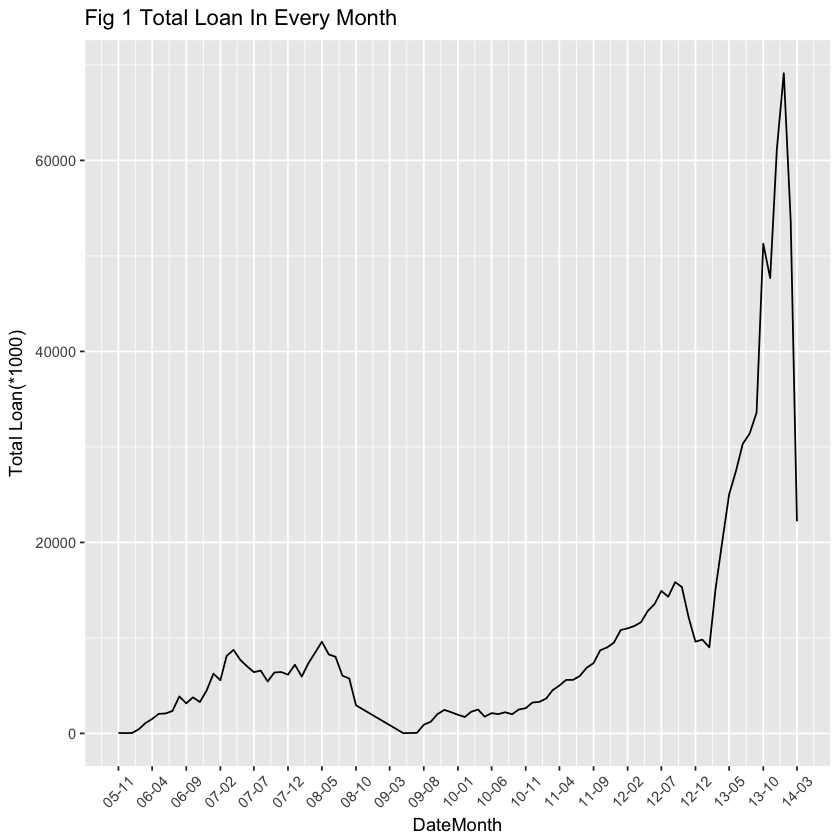

In [12]:
# plot the total loan in every month
ggplot() +
    geom_line(aes(x=DateMonth, y=LoanTotal/1000), data=Loanamount) +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 1 Total Loan In Every Month") +
    ylab("Total Loan(*1000)")

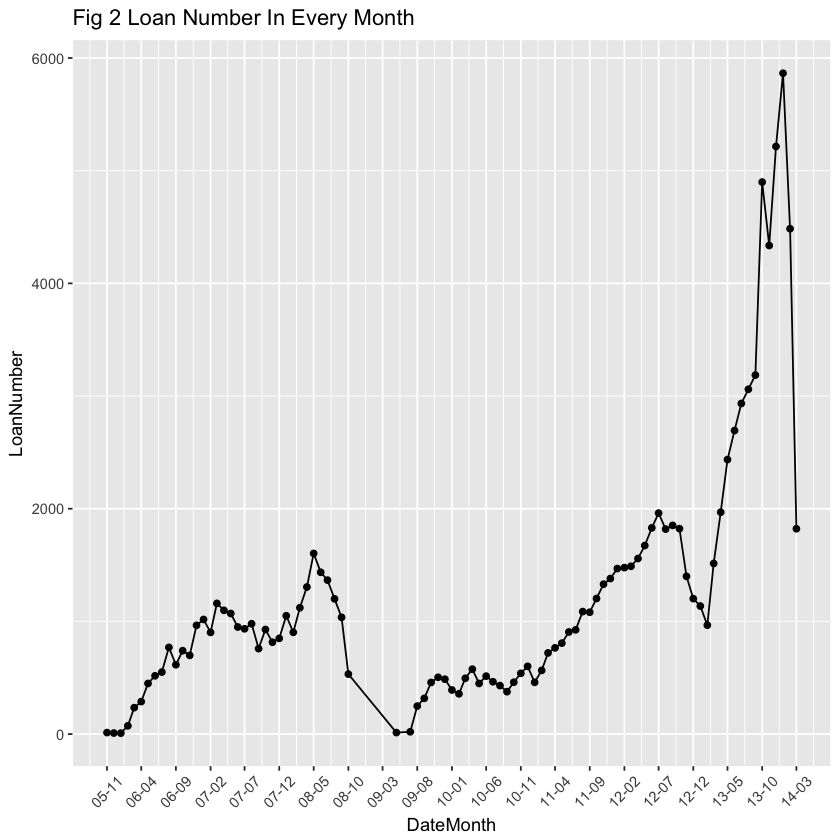

In [13]:
# plot loan number in every month
ggplot(aes(x=DateMonth, y=LoanNumber), data=Loanamount) +
    geom_point() +
    geom_path() +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 2 Loan Number In Every Month") +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m")

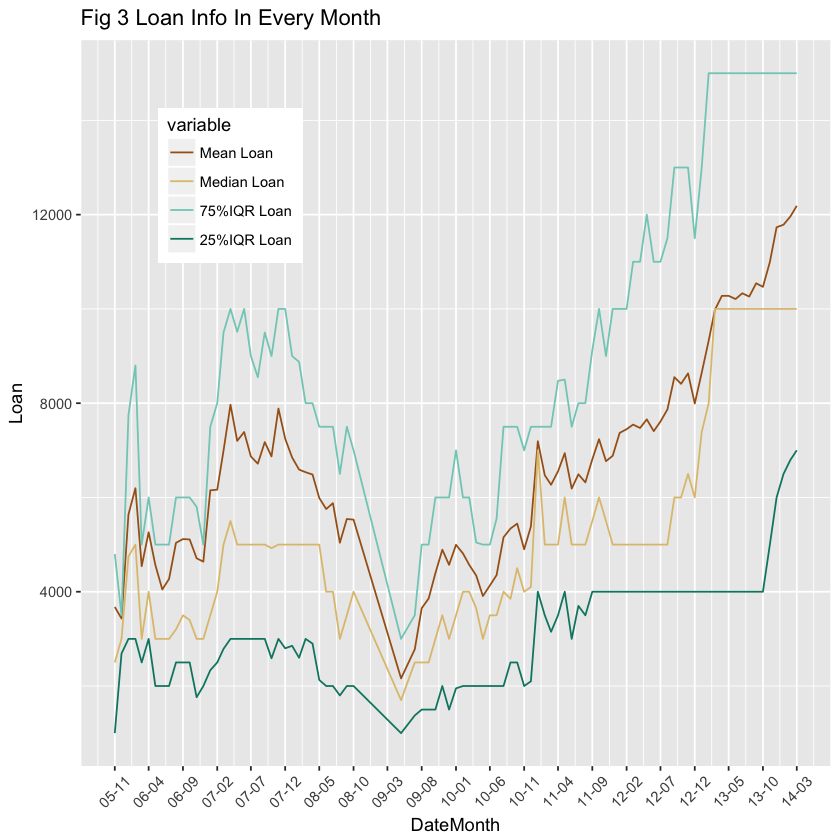

In [14]:
# plot the another stat infomation about loan in every month
Loaninfo <- melt(subset(Loanamount, select=c("DateMonth", "LoanMean", "LoanMedian", "Loan75", "Loan25")),
                 id="DateMonth", measured=c("LoanMean", "LoanMedian", "Loan75", "Loan25"))
Loaninfo$variable <- factor(Loaninfo$variable,
                            levels=c("LoanMean", "LoanMedian", "Loan75", "Loan25"),
                            labels=c("Mean Loan", "Median Loan", "75%IQR Loan", "25%IQR Loan"))

ggplot(aes(x=DateMonth, y=value), data= Loaninfo) +
    geom_line(aes(color=variable)) +
    theme(legend.position=c(0.2,.8)) +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 3 Loan Info In Every Month") +
    ylab("Loan") +
    scale_color_brewer(type="div")

### 单变量分析
#### 1.Prosper平台贷款状况

以上分析了平台上2005年11月至2014年3月份期间的贷款额，从Fig 1每月贷款额的变化和Fig 2每月交易数量：1)整体趋势上，每月的贷款额在增加。到2014年1月至2014年3月出现了贷款总额快速降低的趋势(降低了近5亿)，同时交易数量也快速萎缩；2)在2008年10月至2009年8月期间，线段平滑下降。经证实该平台发生了暂停交易，对平台交易可能存在影响；3)2009年8月至2013年10月是Prosper平台高速发展对阶段。从Fig 3每月贷款对其他其他统计信息来看，平台的贷款额表现还是比较优异——平均贷款额的趋势也是在2009年3月之后开始快速提高，另外在小额贷款一直发展缓慢，但是在6000以上的贷款额度发展比较快速；在2013年10月之后小额贷款快速发展。

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8554 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

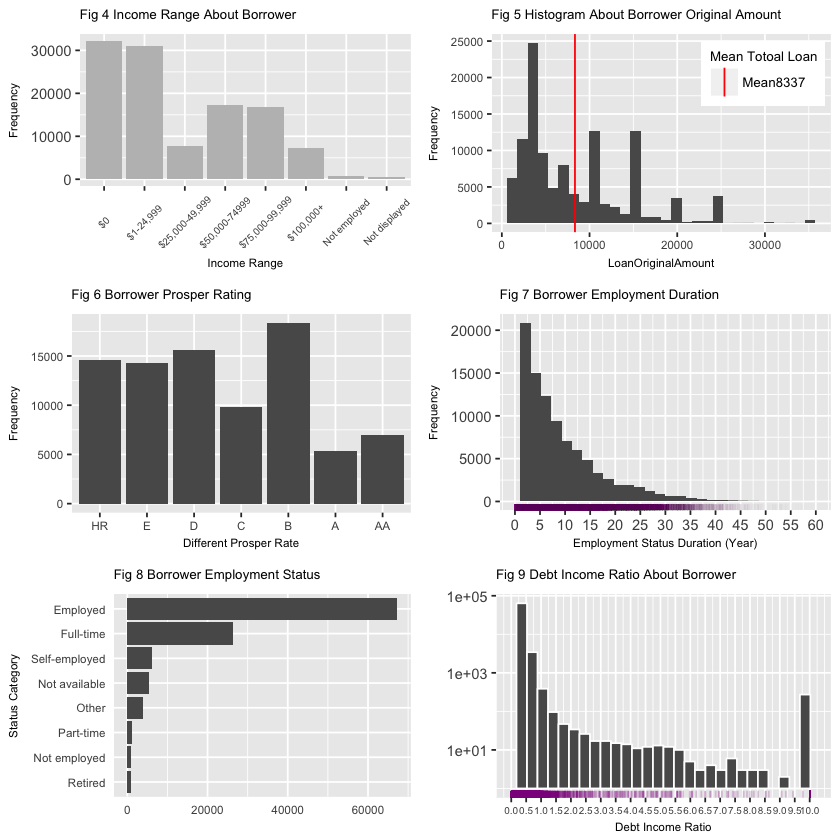

In [84]:
p1 <- ggplot(aes(IncomeRange), data=rawprosper) +
    geom_bar(fill="grey") +
    labs(x="Income Range",y="Frequency", title="Fig 4 Income Range About Borrower") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5, size=6),
          plot.title=element_text(size=8), axis.title = element_text(size=7))
p2 <- ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_histogram() +
    geom_vline(aes(xintercept=mean(rawprosper$LoanOriginalAmount),colour="Mean8337")) + # adding legend
    scale_colour_manual(name="Mean Totoal Loan", values=c(Mean8337="red")) +
    ggtitle("Fig 5 Histogram About Borrower Original Amount") +
    ylab("Frequency") +
    theme(plot.title=element_text(size=8),legend.position=c(.8,.8),
          legend.title=element_text(size=8), legend.text=element_text(size=8),
          axis.title = element_text(size=7), axis.text=element_text(size=7))

p3 <- ggplot(aes(ProsperRatingAlpha), data=subset(rawprosper, ProsperRatingAlpha != "NA")) +
    geom_bar() +
    ggtitle("Fig 6 Borrower Prosper Rating") +
    labs(y="Frequency", x="Different Prosper Rate") +
    theme(plot.title=element_text(size=8), axis.title=element_text(size=7),
          axis.text=element_text(size=7))

p4 <- ggplot(aes(x=EmploymentStatusDuration/12), data=subset(rawprosper, !is.na(EmploymentStatusDuration))) +
    geom_histogram()+
    geom_rug(sides="b", na.rm=TRUE, alpha=0.01, color="#8B008B") +
    labs(x="Employment Status Duration (Year)", y="Frequency", title="Fig 7 Borrower Employment Duration") +
    scale_x_continuous(limits=c(0, 60), breaks=seq(0, 60, 5)) +
    theme(plot.title=element_text(size=8), axis.title = element_text(size=7))

p5 <- ggplot(aes(reorder(EmploymentStatus, rep(1, length(EmploymentStatus)), sum)),
             data=subset(rawprosper, EmploymentStatus != "NA")) +
    geom_bar() +
    theme(axis.ticks=element_blank()) +
    coord_flip() +
    labs(x="Status Category", y="", title="Fig 8 Borrower Employment Status") +
    theme(plot.title=element_text(size=8), axis.title = element_text(size=7),
         axis.text=element_text(size=7)) # fix the axis text font size

p6 <- ggplot(aes(DebtToIncomeRatio), data=subset(rawprosper, !is.nan(DebtToIncomeRatio))) +
    geom_histogram(color="white") +
    geom_rug(alpha=0.2,color="#8B008B") +
    scale_y_log10() +
    labs(x="Debt Income Ratio", y="", title="Fig 9 Debt Income Ratio About Borrower") +
    scale_x_continuous(limits=c(0, 10.2), breaks=seq(0, 10.2, .5)) +
#     theme(axis.text.y = element_blank()) +
    theme(plot.title=element_text(size=8), axis.title = element_text(size=7), axis.text.x=element_text(size=6))

# plot the all information about borrower
grid.arrange(p1, p2, p3, p4, p5, p6, ncol=2)

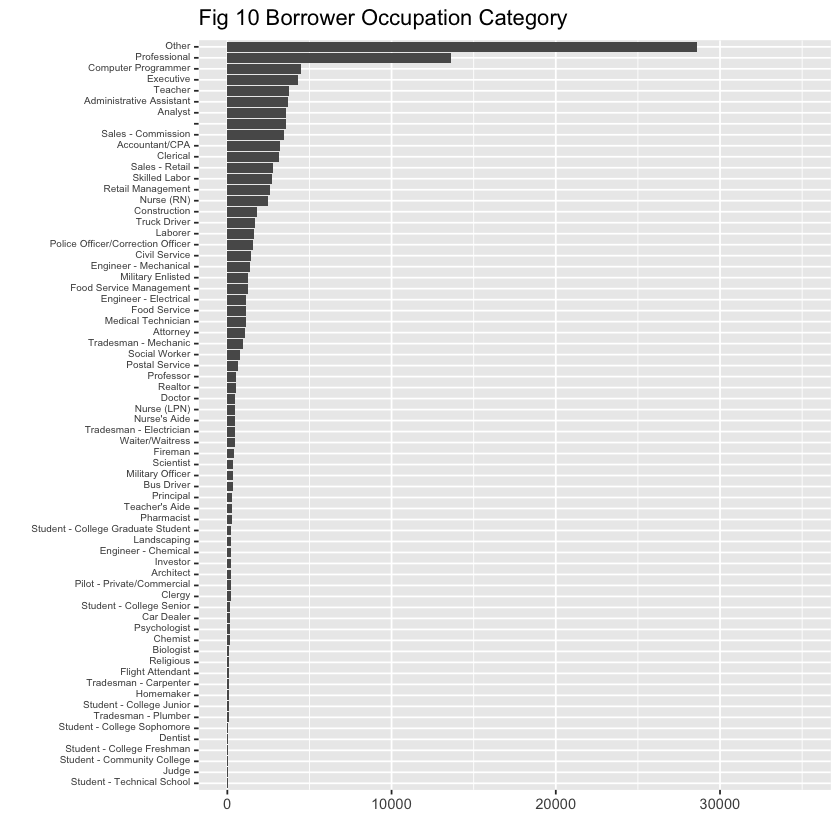

In [83]:
# borrower occupation category
ggplot(aes(reorder(Occupation, rep(1, length(Occupation)), sum)), data=subset(rawprosper, !is.na(Occupation))) +
    geom_bar() +
    coord_flip() +
    ggtitle("Fig 10 Borrower Occupation Category") +
    xlab("") +
    ylab("") +
    scale_y_continuous(limits=c(0, 35000)) +
    theme(axis.text.y = element_text(size=6, vjust=.2))

#### 2.借款人发生贷款时的信息侧写

从借款人的收入情况，开始借款的借款额度，Prosper的信用评级、借款人的工作时间，借款人借款时的工作状态、收入债务比以及职务分类等方面进行了分析，可以发现以下信息：

* 借款人收入情况 从Fig 4 收入范围分布和Fig 9 收入债务比中分析，显示在借款时的收入主要是收入在24,999以下的，另一方面中等收入(收入在50,000至99,999范围内)的借款也相对较高。推测在中等收入借款较高，可能和消费观念有关

* 借款额度方面 可以看出大部分的借款人借款额度都在15000以内，而且平均借款额度在8337左右。另外有借款额度过高的，超过了30000。推测大多人的借款额度没有超过他们的收入，关于这点需要从Fig 9收入债务比来分析，从图中可以看出主要的债务占收入的比重在0.5左右，有少量的借款人的债务占比还是过高达到了10以上，。对借款额度作为投资分析参数，还需要深入分析

* Prosper信用评级方面 借款人的信用评级主要集中HR、E、D、C以及B之间，而在优质等级(A和AA)中发生借款的人数相对较少。可能是Prosper平台的信用评级较严格，这样可以提供一个良好的参数以方便投资人的投资选择。针对这个参数的参考，需要继续分析

* 借款人工作情况 从Fig 7借款人工作实线和Fig 8借款人借款状态来看，主要借款人是有工作的——全职工作人员和被雇佣的人员借款次数角度。同时在工作时限上，可以看出工作了0——10年的借款人比较集中，因为这个时期恰好是身份转换等身份条件变化的时期。

* 借款人职务 从Fig 10展示的借款人的职务来看，职务信息不是很全面。因为在选择职务为Other的借款人明显偏多，不具有显著对分析作用。针对这一点，涉及到个人隐私等方面的问题。但是从其他数据职务数据来看受教育的借款人员——教授、编程工作人员、行政人员等，发生借款次数较多

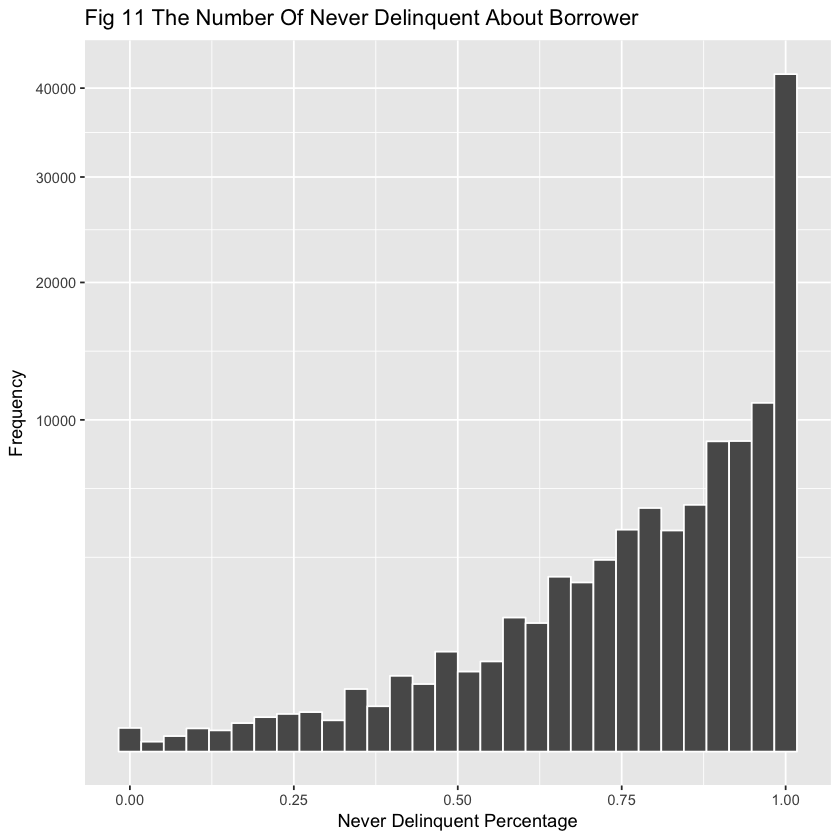

In [124]:
# rawprosper$TotalTrades
ggplot(aes(TradesNeverDelinquentPercentage), data=subset(rawprosper, !is.na(TradesNeverDelinquentPercentage))) +
    geom_histogram(color="white", bins=30) +
    scale_y_sqrt() +
    labs(x="Never Delinquent Percentage", y="Frequency",
        title="Fig 11 The Number Of Never Delinquent About Borrower") 
#     scale_y_continuous(limits=c())
#     coord_trans(y="sqrt")
#     scale_y_sqrt()

In [127]:
# cut the sequence
nodelinquent_percent <- cut(rawprosper$TradesNeverDelinquentPercentage,
    breaks=seq(0.00, 1.10, 0.10), right=FALSE)

# ratio of different nondelinquent percentage
options(digits=4)
table(nodelinquent_percent) / length(nodelinquent_percent) * 100

nodelinquent_percent
  [0,0.1) [0.1,0.2) [0.2,0.3) [0.3,0.4) [0.4,0.5) [0.5,0.6) [0.6,0.7) [0.7,0.8) 
  0.07724   0.14306   0.38179   0.50115   0.98563   3.22634   6.03930   8.43624 
[0.8,0.9)   [0.9,1)   [1,1.1) 
 15.08729  21.89719  36.60356 

#### 3.借款人的还款

因为投资人的收益是从借款人的还款中回收本金和赚取收益，因此如果发生了违反合约的情况时，将影响到投资人的收益情况。从Fig 11借款人未违反合约的比例和未违反合约比例的占总体比率，反应出发生违反合约的比例较少(完全未发生违约的比例占到了36.603%)，可以看出在Prosper平台上的投资环境还是良性的。

Warning message:
“Removed 1 rows containing missing values (geom_bar).”Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

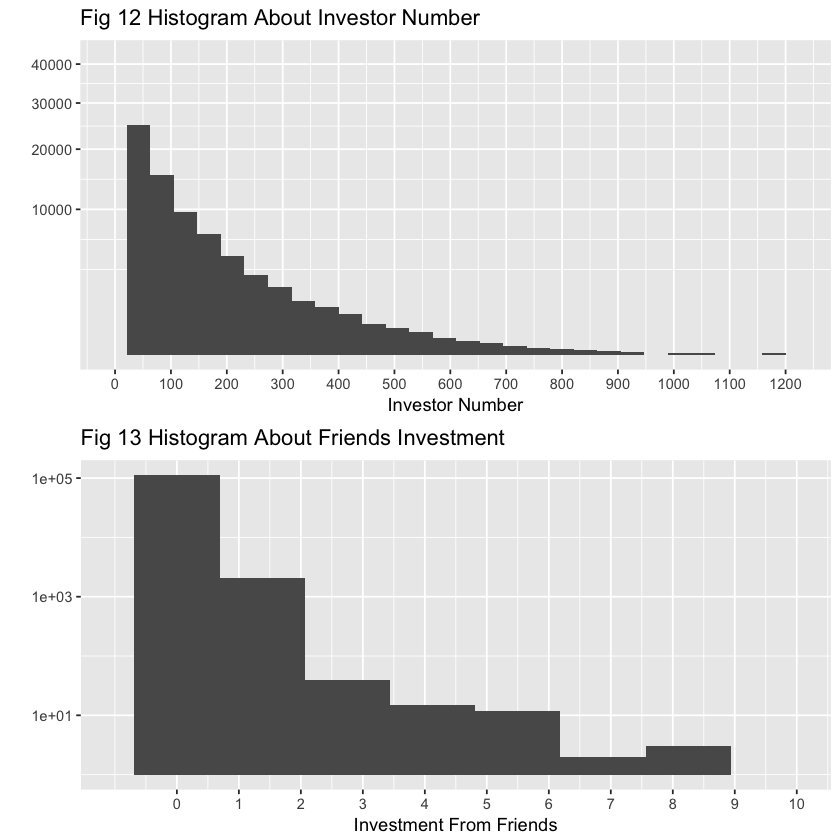

In [165]:
# information about lender
p1 <- ggplot(aes(Investors), data=rawprosper) +
    geom_histogram(bins=30) +
    scale_y_sqrt() +
    labs(x="Investor Number", y="", title="Fig 12 Histogram About Investor Number") +
    scale_x_continuous(limits=c(-1, 1220), breaks=seq(0, 1220, 100))
p2 <- ggplot(aes(InvestmentFromFriendsCount), data=rawprosper) +
    geom_histogram(bins=9) +
    scale_y_log10() +
    labs(x="Investment From Friends", y="", title="Fig 13 Histogram About Friends Investment") +
    scale_x_continuous(limits=c(-1, 10), breaks=seq(0, 10, 1))
grid.arrange(p1, p2, ncol=1)

In [140]:
# investor number in different 
table(cut(rawprosper$Investors, breaks=seq(0, 400, 100)))


  (0,100] (100,200] (200,300] (300,400] 
    81470     19372      7790      3119 

In [145]:
# friend investor number
table(rawprosper$InvestmentFromFriendsCount)


     0      1      2      3      4      5      6      7      8      9     13 
111806   1835    215     40     15      8      4      2      3      5      1 
    15     20     33 
     1      1      1 

In [166]:
summary(rawprosper$InvestmentFromFriendsCount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.02    0.00   33.00 

#### 4.投资人信息分析

从投资人角度，主要分析Prosper平台上了解投资人对借款人的投资情况。Fig 12对借款人投资的人数和Fig 13借款来自于朋友投资人数，展示了相关信息：
* 单笔借款投资人数 单笔投资人数主要是在100人以内，投资人的数量可能会和借款人的借款额度有相关性——低额度借款可能并不需要太多的投资人，相反高额度会需要多人投资。关于这点需要继续分析
* 朋友投资 从Fig 13中可以看出，大部分的投资人数都是来自于非熟悉的投资人(完全来自于非朋友投资的交易数达到了111,806笔)，也就是说大部分投资人在进行投资时，并没有以与被投资人是否为朋友关系为参考标准

### 单变量分析总结
单变量分析中，从投资平台的发展情况、发生借款时借款人信息以及投资人角度分别进行了分析。投资平台发展总体发展较快，但是在2014年1月至2014年3月期间借款额发生急剧萎缩，作为投资人需要注意该平台的后续发展；借款人角度方面，总体来看借款人在借款时处于合理的借款范围。且从违反合约的角度来看，还款情况还是在合理的，投资人的损失率还是较低——关于这点需要进行继续分析；投资人角度来看，投资人参考信息还是相对的理性。

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


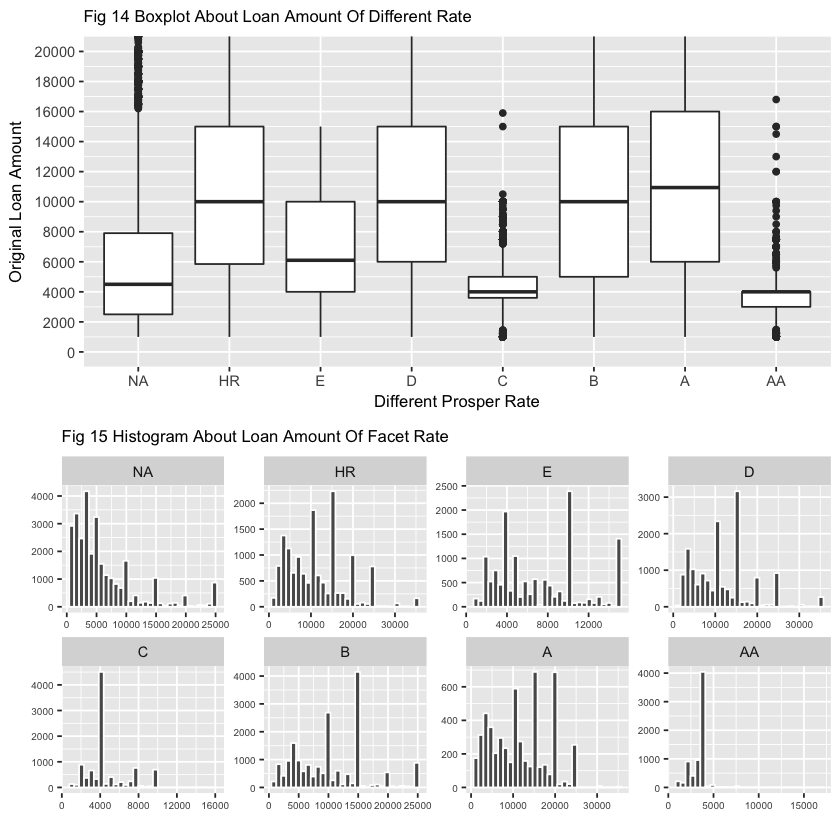

In [230]:
# original loan amount about prosper rate
p1 <- ggplot(aes(x=ProsperRatingAlpha, y=LoanOriginalAmount), data=rawprosper) +
    geom_boxplot() +
    labs(x="Different Prosper Rate", y="Original Loan Amount",
         title="Fig 14 Boxplot About Loan Amount Of Different Rate") +
    scale_y_continuous(breaks=seq(0, 20000, 2000)) +
    theme(axis.title=element_text(size=10), plot.title=element_text(size=10)) +
    coord_cartesian(ylim=c(0, 20000))

p2 <- ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_histogram(color="white") +
    facet_wrap(~ProsperRatingAlpha, nrow=2, scales="free") +
    labs(y="", x="", title="Fig 15 Histogram About Loan Amount Of Facet Rate") +
    theme(axis.text=element_text(size=6), plot.title=element_text(size=10))
grid.arrange(p1, p2, nrow=2)

In [182]:
by(rawprosper$LoanOriginalAmount, rawprosper$ProsperRatingAlpha, summary)

rawprosper$ProsperRatingAlpha: NA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    2500    4500    6159    7904   25000 
------------------------------------------------------------ 
rawprosper$ProsperRatingAlpha: HR
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    5850   10000   11460   15000   35000 
------------------------------------------------------------ 
rawprosper$ProsperRatingAlpha: E
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    4000    6100    7083   10000   15000 
------------------------------------------------------------ 
rawprosper$ProsperRatingAlpha: D
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    6000   10000   11622   15000   35000 
------------------------------------------------------------ 
rawprosper$ProsperRatingAlpha: C
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    3600    4000    4586    5000   15900 
------------------------------------------------------------ 
rawprosper$ProsperRatingAlpha: B


### 双变量分析
#### 1. Prosper不同信用等级申请贷款额
从不同信用等级和借款额度分析，各等级的主要贷款额度都是在4000至15000之间，最大借款额为35000，最小借款额为1000，其中AA级和C级的借款额度相对要小很多——AA级主要集中在3000-4000之间，C级主要集中在3500-5000之间。从Fig 15反应出了，低等级的借款人中存在大额度借款，从投资人的角度需要注意这类借款人是否值得投资，例如HR等级存在超过30000的借款。

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


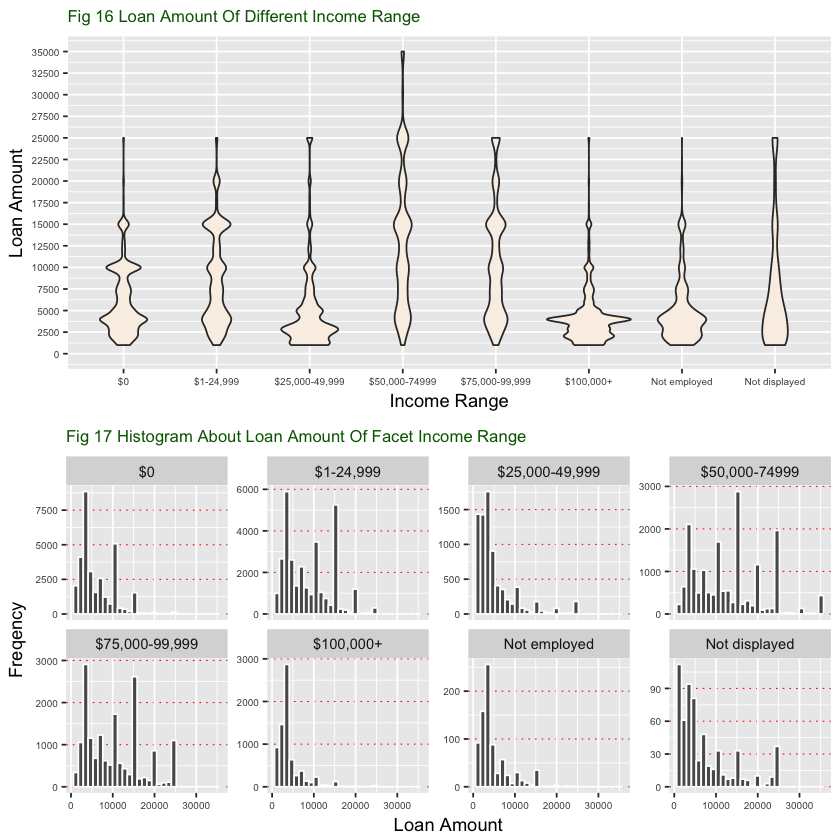

In [226]:
# loan amount and income range
p1 <- ggplot(aes(x=IncomeRange, y=LoanOriginalAmount), data=rawprosper) +
    geom_violin(fill="#FAF0E6") +
    labs(y="Loan Amount", x="Income Range",
         title="Fig 16 Loan Amount Of Different Income Range") +
    scale_y_continuous(limits=c(0, 35000), breaks=seq(0, 35000, 2500)) +
    theme(axis.text=element_text(size=6), plot.title=element_text(size=10, color="#006400"))

p2 <- ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_histogram(color="white") +
    facet_wrap(~IncomeRange, nrow=2, scale="free_y") +
    labs(y="Freqency", x="Loan Amount", title="Fig 17 Histogram About Loan Amount Of Facet Income Range") +
    theme(axis.text=element_text(size=6), plot.title=element_text(size=10, color="#006400"),
          panel.grid.major.y=element_line(color="red", linetype=3, size=0.3))

grid.arrange(p1, p2, nrow=2)

In [212]:
by(rawprosper$LoanOriginalAmount, rawprosper$IncomeRange, summary)

rawprosper$IncomeRange: $0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    3000    5000    6178    9800   25000 
------------------------------------------------------------ 
rawprosper$IncomeRange: $1-24,999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    4000    7500    8675   13500   25000 
------------------------------------------------------------ 
rawprosper$IncomeRange: $25,000-49,999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    2100    3033    5170    6001   25000 
------------------------------------------------------------ 
rawprosper$IncomeRange: $50,000-74999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    6000   12000   13073   18500   35000 
------------------------------------------------------------ 
rawprosper$IncomeRange: $75,000-99,999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    4000    9700   10366   15000   25000 
------------------------------------------------------------ 
rawprosper$IncomeRange:

#### 2. 不同收入水平和借款额度

从不同的收入水平和借款额度来分析，借款额度基本上都集中在2500-14000之间。但是高水平收入中借款额度相对较小(主要集中在2052-5000)，从投资角度看，如果其债务收入比较低，整体投资稳定性肯定是要高于低收入甚至无收入的借款人。对于无收入的借款人存在大额借款，此类投资风险较高。从借款额度和收入水平来看，对收入在25,000-100,000的借款人相对较合理。但是还需要综合考虑借款人对债务收入比以及其他相关信息

Warning message:
“Removed 8554 rows containing non-finite values (stat_ydensity).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8554 rows containing non-finite values (stat_bin).”

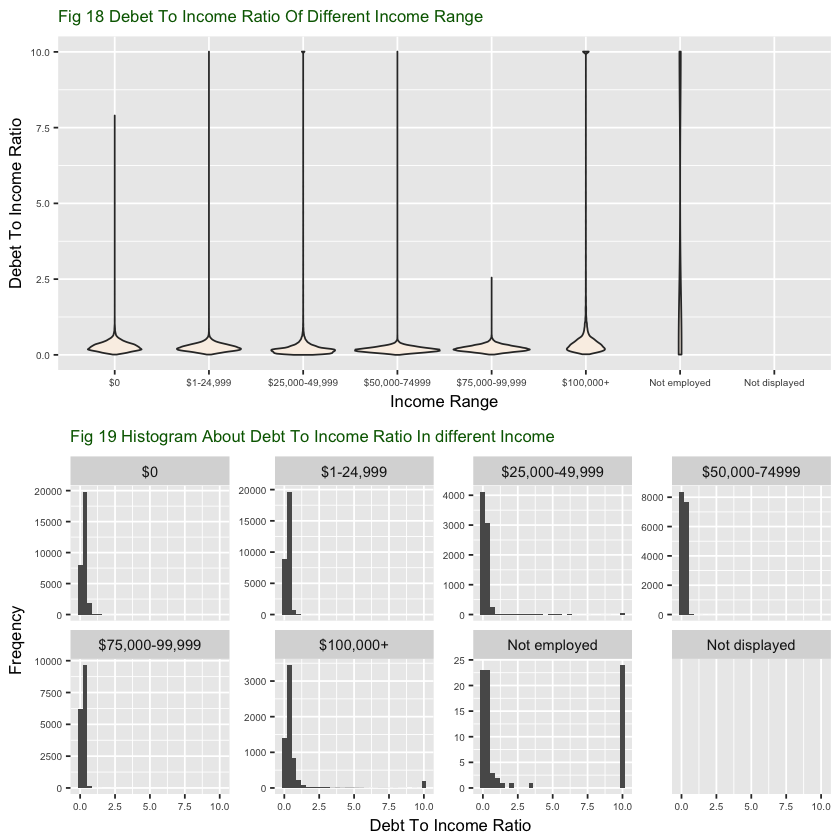

In [243]:
# debet to income ratio in different income range
p1 <- ggplot(aes(x=IncomeRange, y=DebtToIncomeRatio), data=rawprosper) +
    geom_violin(fill="#FAF0E6") +
    labs(y="Debet To Income Ratio", x="Income Range",
         title="Fig 18 Debet To Income Ratio Of Different Income Range") +
    theme(axis.text=element_text(size=6), plot.title=element_text(size=10, color="#006400"),
         axis.title=element_text(size=10))
p2 <- ggplot(aes(DebtToIncomeRatio), data=rawprosper) +
    geom_histogram() +
    facet_wrap(~IncomeRange, nrow=2, scale="free_y") +
    labs(x="Debt To Income Ratio", y="Freqency",
         title="Fig 19 Histogram About Debt To Income Ratio In different Income") +
    theme(axis.text=element_text(size=6), plot.title=element_text(size=10, color="#006400"),
          axis.title=element_text(size=10))

grid.arrange(p1, p2, nrow=2)

In [249]:
# info about debt to income ratio in different income range
by(rawprosper$DebtToIncomeRatio, rawprosper$IncomeRange, summary)

rawprosper$IncomeRange: $0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.2     0.3     0.3     0.4     7.9    2311 
------------------------------------------------------------ 
rawprosper$IncomeRange: $1-24,999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.2     0.2     0.2     0.3    10.0    1690 
------------------------------------------------------------ 
rawprosper$IncomeRange: $25,000-49,999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.09    0.16    0.30    0.26   10.01     124 
------------------------------------------------------------ 
rawprosper$IncomeRange: $50,000-74999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.1     0.2     0.2     0.2    10.0    1266 
------------------------------------------------------------ 
rawprosper$IncomeRange: $75,000-99,999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.1     0.2     0.2     0.3     2.5     901 
-----

In [250]:
# group income range about debt to income ratio over 10
rawprosper %>%
    filter(DebtToIncomeRatio >=10.0) %>%
    group_by(IncomeRange) %>%
    summarise(ratio_over_10=n())

IncomeRange,ratio_over_10
"$1-24,999",1
"$25,000-49,999",59
"$50,000-74999",1
"$100,000+",187
Not employed,24


#### 3. 不同收入水平的债务收入比分析
从Fig 18不同收入水平的收入和债务收入比的Violin图、Fig 19的直方图以及分析数据中，可以看出有大部分的借款人都能将债务收入比控制在0.15至0.3之间——从借款人和投资人的角度来说，能够良好的控制债务收入的关系才是获取稳健投资和借款的可能性。但是在Fig 19中表现出了一个明显的问题，未工作的借款人和高收入者(收入超过100,000)中存在债务收入比超过10的借款人，虽然总体数量偏少(交易数量有272笔——其中高收入高债务比的借款人交易数为187，而未工作高债务比的借款人交易数为24)。可能高收入者的高债务比是临时性的，但是从投资角度都需要警惕此类交易行为。

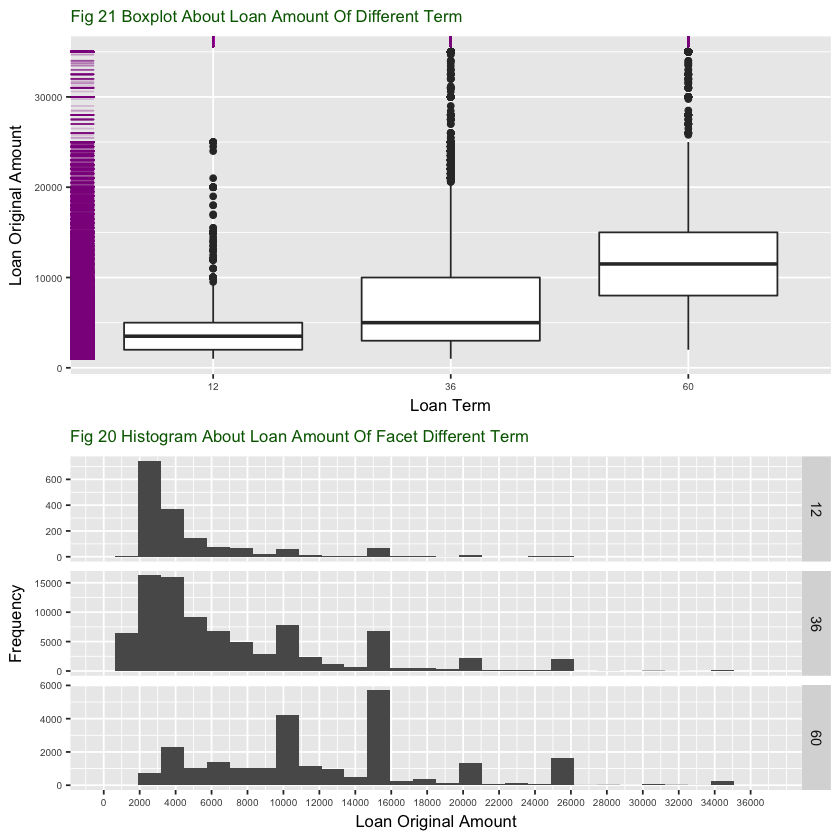

In [288]:
# loan amount of different term
p2 <- ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_histogram(bins=30) +
    facet_grid(Term~., scales ="free") +
    bivariate_theme +
    labs(x="Loan Original Amount", y="Frequency",
         title="Fig 20 Histogram About Loan Amount Of Facet Different Term") +
    scale_x_continuous(limits=c(0, 37000), breaks=seq(0, 37000, 2000))

p1 <- ggplot(aes(x=factor(Term), y=LoanOriginalAmount), data=rawprosper) +
    geom_boxplot() +
    geom_rug(sides="left", alpha=0.2,color="#8B008B") +
    bivariate_theme +
    labs(x="Loan Term", y="Loan Original Amount",
         title="Fig 21 Boxplot About Loan Amount Of Different Term")

grid.arrange(p1, p2, nrow=2)

In [287]:
table(rawprosper$Term)


   12    36    60 
 1614 87778 24545 

In [300]:
# cut the loan amount and analysis the differen loan term
testdata <- mutate
rawprosper %>%
    mutate(LoanAmount = cut(LoanOriginalAmount, breaks=seq(0, max(LoanOriginalAmount) + 2000, 2000))) %>%
    group_by(LoanAmount, Term) %>%
    summarise(number=n()) %>%
    spread(key=Term, value=number)

LoanAmount,12,36,60
"(0,2e+03]",446,11800,294
"(2e+03,4e+03]",667,26482,2709
"(4e+03,6e+03]",187,12213,1508
"(6e+03,8e+03]",110,9024,2006
"(8e+03,1e+04]",81,10341,5092
"(1e+04,1.2e+04]",17,2714,1337
"(1.2e+04,1.4e+04]",13,1817,1400
"(1.4e+04,1.6e+04]",69,7231,5932
"(1.6e+04,1.8e+04]",4,846,442
"(1.8e+04,2e+04]",11,2382,1477


In [286]:
by(rawprosper$LoanOriginalAmount, rawprosper$Term, summary)

rawprosper$Term: 12
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    2000    3500    4694    5000   25000 
------------------------------------------------------------ 
rawprosper$Term: 36
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    3000    5000    7276   10000   35000 
------------------------------------------------------------ 
rawprosper$Term: 60
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2000    8000   11500   12370   15000   35000 

#### 4. 借款额度和计划还款时长
从分析数据来看，三种还款时长中选择中期(36个月)的交易量最多，达到了87,778笔；其次是长期(60个月)的交易量，达到量24,545笔。在Fig 20不同还款时长的借款额度来看，选择短期(12个月)还款的策略中，主要的借款额度集中在2,000-4,000之间；而借款额度在2,000-15,000范围的长期选择长期还款的交易量，相对来说分布比较均匀。但是在8,000-10,000范围和14,000-16,000范围内的长期还款策略的交易数，异常的高分别达到量5092笔和5932笔。从分析和预测来看，借款额度和还款策略可能与收入等存在相关性，需要进一步分析。

Warning message:
“Removed 16049 rows containing non-finite values (stat_summary).”

Warning message:
“Removed 16049 rows containing non-finite values (stat_summary).”

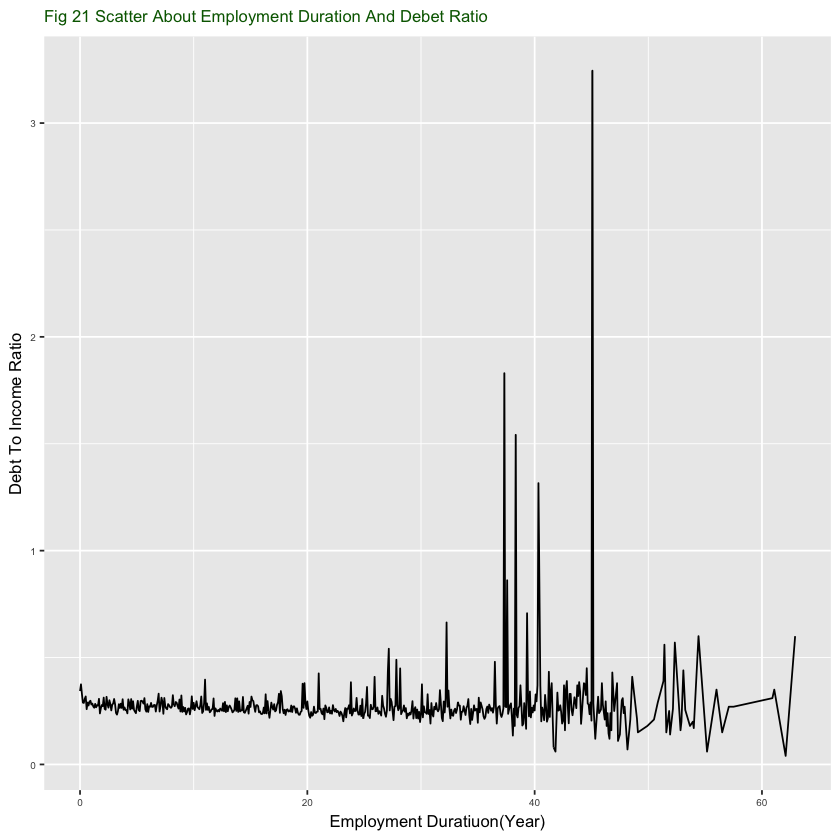

Warning message:
“Removed 7625 rows containing missing values (geom_path).”

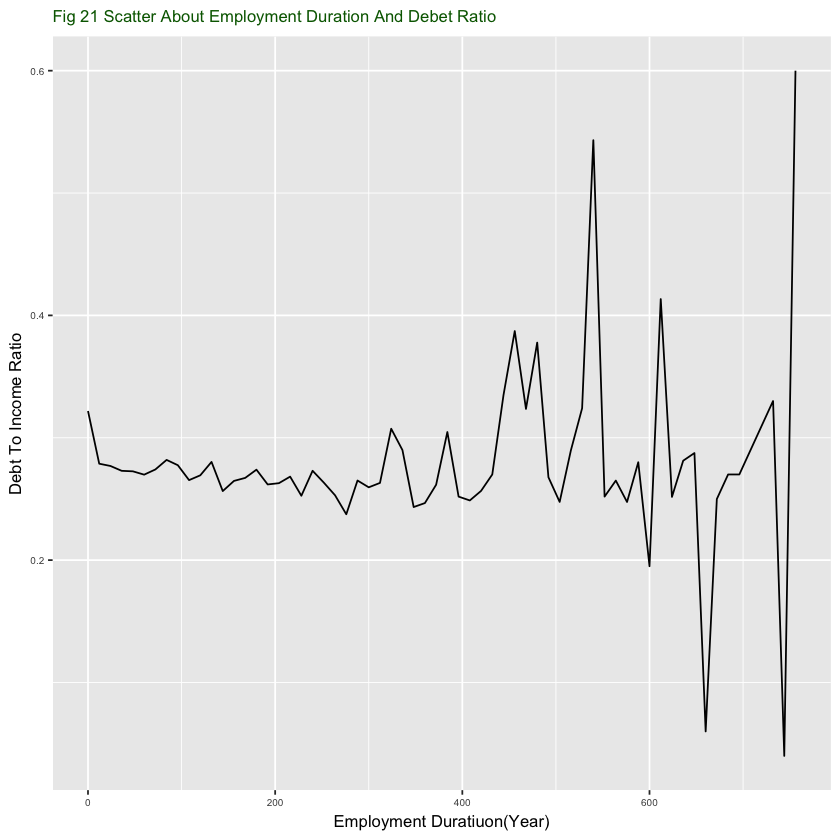

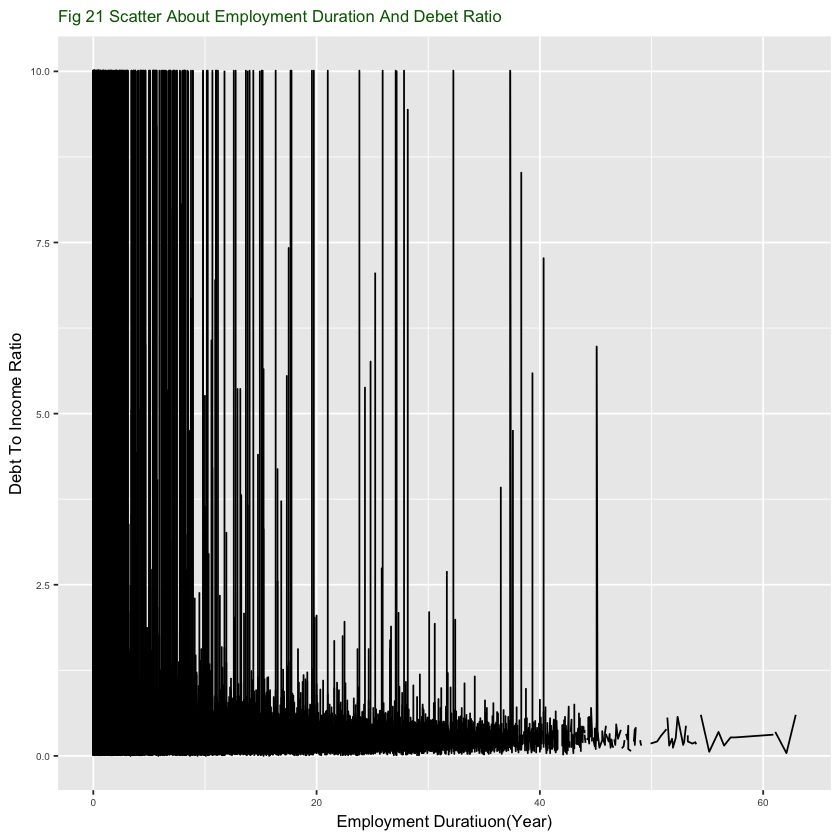

In [338]:
ggplot(aes(x=EmploymentStatusDuration/12, y=DebtToIncomeRatio), data=rawprosper) +
#     geom_point(alpha=0.5, position="jitter") +
    geom_line(stat="summary", fun.y=mean) +
    bivariate_theme +
    labs(x="Employment Duratiuon(Year)", y="Debt To Income Ratio",
         title="Fig 21 Scatter About Employment Duration And Debet Ratio")
ggplot(aes(x=12 * round(EmploymentStatusDuration/12), y=DebtToIncomeRatio), data=rawprosper) +
#     geom_point(alpha=0.5, position="jitter") +
    geom_line(stat="summary", fun.y=mean) +
    bivariate_theme +
    labs(x="Employment Duratiuon(Year)", y="Debt To Income Ratio",
         title="Fig 21 Scatter About Employment Duration And Debet Ratio")
ggplot(aes(x=EmploymentStatusDuration/12, y=DebtToIncomeRatio), data=rawprosper) +
#     geom_point(alpha=0.5, position="jitter") +
    geom_line() +
    bivariate_theme +
    labs(x="Employment Duratiuon(Year)", y="Debt To Income Ratio",
         title="Fig 21 Scatter About Employment Duration And Debet Ratio")

In [18]:
sort(names(rawprosper))

[1] "AmountDelinquent"                    "AvailableBankcardCredit"            
 [3] "BankcardUtilization"                 "BorrowerAPR"                        
 [5] "BorrowerRate"                        "BorrowerState"                      
 [7] "ClosedDate"                          "CreditGrade"                        
 [9] "CreditScoreRangeLower"               "CreditScoreRangeUpper"              
[11] "CurrentCreditLines"                  "CurrentDelinquencies"               
[13] "CurrentlyInGroup"                    "DateCreditPulled"                   
[15] "DebtToIncomeRatio"                   "DelinquenciesLast7Years"            
[17] "EmploymentStatus"                    "EmploymentStatusDuration"           
[19] "EstimatedEffectiveYield"             "EstimatedLoss"                      
[21] "EstimatedReturn"                     "FirstRecordedCreditLine"            
[23] "GroupKey"                            "IncomeRange"                        
[25] "IncomeVerifiable"                    "InquiriesLast6Months"               
[27] "InvestmentFromFriendsAmount"         "InvestmentFromFriendsCount"         
[29] "Investors"                           "IsBorrowerHomeowner"                
[31] "LP_CollectionFees"                   "LP_CustomerPayments"                
[33] "LP_CustomerPrincipalPayments"        "LP_GrossPrincipalLoss"              
[35] "LP_InterestandFees"                  "LP_NetPrincipalLoss"                
[37] "LP_NonPrincipalRecoverypayments"     "LP_ServiceFees"                     
[39] "LenderYield"                         "ListingCategoryNumeric"             
[41] "ListingCreationDate"                 "ListingKey"                         
[43] "ListingNumber"                       "LoanCurrentDaysDelinquent"          
[45] "LoanFirstDefaultedCycleNumber"       "LoanKey"                            
[47] "LoanMonthsSinceOrigination"          "LoanNumber"                         
[49] "LoanOriginalAmount"                  "LoanOriginationDate"                
[51] "LoanOriginationQuarter"              "LoanStatus"                         
[53] "MemberKey"                           "MonthlyLoanPayment"                 
[55] "Occupation"                          "OnTimeProsperPayments"              
[57] "OpenCreditLines"                     "OpenRevolvingAccounts"              
[59] "OpenRevolvingMonthlyPayment"         "PercentFunded"                      
[61] "ProsperPaymentsLessThanOneMonthLate" "ProsperPaymentsOneMonthPlusLate"    
[63] "ProsperPrincipalBorrowed"            "ProsperPrincipalOutstanding"        
[65] "ProsperRatingAlpha"                  "ProsperRatingNumeric"               
[67] "ProsperScore"                        "PublicRecordsLast10Years"           
[69] "PublicRecordsLast12Months"           "Recommendations"                    
[71] "RevolvingCreditBalance"              "ScorexChangeAtTimeOfListing"        
[73] "StatedMonthlyIncome"                 "Term"                               
[75] "TotalCreditLinespast7years"          "TotalInquiries"                     
[77] "TotalProsperLoans"                   "TotalProsperPaymentsBilled"         
[79] "TotalTrades"                         "TradesNeverDelinquentPercentage"    
[81] "TradesOpenedLast6Months"

## 参考
1. [马赛克图](https://itunes.apple.com/cn/album/waiting-for-the-end-the-glitch-mob-remix/397873565?i=397873589)
2. [条形图梯度排序](https://ask.hellobi.com/blog/Data_AnalysisR/8808)
3. [ggplot部分中文参考](https://wlz0726.github.io/2017/01/01/R-Cheetsheets/)